### CE 295 - Final Project Code
##### Optimization of a New California Desalination Plant
###### Code produced by Natalie Alvarado & Aidan Hasegawa

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from cvxpy import *
%matplotlib inline
import pandas as pd
from datetime import datetime
import seaborn as sns

In [2]:
# define parameters

# system parameters
n = 20 # plant lifetime
dis = 0.05 # annual discount rate
Ed = 31666 #power demand for plant (kW)

# battery data
eta = 0.98 #inverter efficiency
sigma = 0.0002 #hourly discharge rate
DOD = 1 
SBS = 100000 #(kW)
Ebmin = (1 - DOD)*SBS
Ebmax = 100000 #(kW)

# solar power data
prs = 0.45 #rated power of solar panel (kW)
Tno = 44 # normal operating temp (C)
Nt = 3.7*10**(-3) #(1/C)

# wind turbine data
WSci = 3 #Cut-in wind speed (m/s)
WSr = 11.5 #Rated wind speed (m/s)
WSco = 25 #Cut-off wind speed (m/s)
prw = 2300 #rated power of wind turbine (kW)
a = prw / (WSr**3 - WSci**3)
b = WSci**3 / (WSr**3 - WSci**3)

# cost for solar pv, wind turbine, battery per year
cap_wt = 2990000/n #USD/yr
om_wt = 45000 #USD/yr
c_wt = cap_wt + om_wt #USD/yr

cap_pv = 200/n #USD/yr
om_pv = 5.4 #USD/yr
c_pv = cap_pv + om_pv #USD/yr

cap_b = 48000000/n #USD/yr 
om_b = 132520 #USD/yr
c_b = cap_b + om_b 

# cost of desal stuff
capacity_RO = 190000*365 #(m3/yr)
c_ROsys = 0.18*capacity_RO #USD/yr
c_membrane = 441000 #membrane replacement cost (USD/yr)
om_RO = 0.2*capacity_RO #USD/yr
c_chem = 1331000 #USD/yr
c_inverter = (7674.43*2/n)*2 #USD/yr for 2 inverters
om_inverter = 250*2 #USD/yr for 2 inverters
c_sys = c_ROsys + c_membrane + om_RO + c_chem + c_inverter + om_inverter
CRF = dis*(1+dis)**(n) / (1 + dis)**(n-1)

# Bodega Bay Analysis

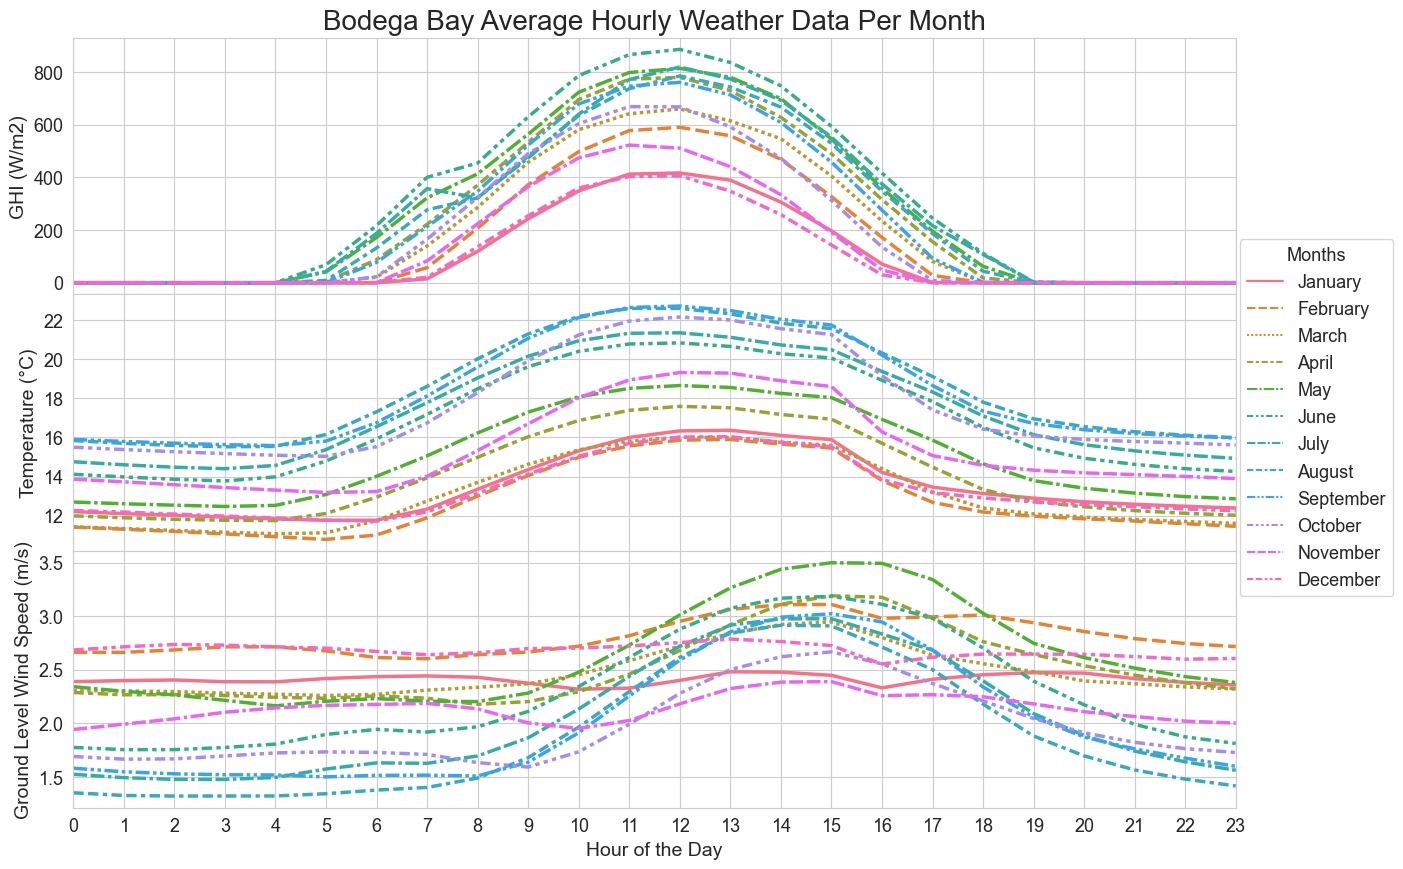

In [3]:
# Bodega Bay Data
# wind speed, GHI, & temp data
# import the data

# bodega bay 2018
df_BB18 = pd.read_csv('BB18.csv')
df_BB18.columns = df_BB18.iloc[1]
df_BB18 = df_BB18[2:]

# bodega bay 2019
df_BB19 = pd.read_csv('BB19.csv')
df_BB19.columns = df_BB19.iloc[1]
df_BB19 = df_BB19[2:]

# bodega bay 2020
df_BB20 = pd.read_csv('BB20.csv')
df_BB20.columns = df_BB20.iloc[1]
df_BB20 = df_BB20[2:]

# bodega bay 2021
df_BB21 = pd.read_csv('BB21.csv')
df_BB21.columns = df_BB21.iloc[1]
df_BB21 = df_BB21[2:]

df_BB = pd.DataFrame()
df_BB = pd.concat([df_BB18, df_BB19, df_BB20, df_BB21], ignore_index=True)

# making all values numeric
df_BB['GHI'] = pd.to_numeric(df_BB['GHI'], errors='coerce')
df_BB['Temperature'] = pd.to_numeric(df_BB['Temperature'], errors='coerce')
df_BB['Wind Speed'] = pd.to_numeric(df_BB['Wind Speed'], errors='coerce')

monthlyGHI = []
monthlyTemp = []
monthlyWS = []

MoY = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

# iterate over all months
for month in df_BB['Month'].unique():
    
    idx = df_BB['Month'] == month

    
    # hourly averages for GHI, temp, & wind speed
    hourly_GHI = df_BB[idx].groupby('Hour')['GHI'].mean()
    hourly_Temp = df_BB[idx].groupby('Hour')['Temperature'].mean()
    hourly_WS = df_BB[idx].groupby('Hour')['Wind Speed'].mean()
    
   # sort hour in order from 0 to 23
    hourly_GHI.index = pd.Categorical(hourly_GHI.index.astype(str), categories=[str(i) for i in range(24)], ordered=True)
    hourly_GHI.sort_index(inplace=True)
    
    hourly_Temp.index = pd.Categorical(hourly_Temp.index.astype(str), categories=[str(i) for i in range(24)], ordered=True)
    hourly_Temp.sort_index(inplace=True)
    
    hourly_WS.index = pd.Categorical(hourly_WS.index.astype(str), categories=[str(i) for i in range(24)], ordered=True)
    hourly_WS.sort_index(inplace=True)
    
    # append
    monthlyGHI.append(hourly_GHI)
    monthlyTemp.append(hourly_Temp)
    monthlyWS.append(hourly_WS)
    MoY.append(month)

# concatenate
df_BB_GHI = pd.concat(monthlyGHI, axis = 1, keys = MoY)
df_BB_Temp = pd.concat(monthlyTemp, axis = 1, keys = MoY)
df_BB_WS = pd.concat(monthlyWS, axis = 1, keys = MoY)  

BB_GHI = np.array(df_BB_GHI)
BB_GHI.resize((288, 1))
BB_Temp = np.array(df_BB_Temp)
BB_Temp.resize((288, 1))
BB_WS = np.array(df_BB_WS)*1.866 # convert to wind speed at hub height
BB_WS.resize((288, 1))


# # make plots
sns.set_style('whitegrid') # darkgrid, white grid, dark, white and ticks
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=14)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=13)    # fontsize of the tick labels
plt.rc('ytick', labelsize=13)    # fontsize of the tick labels
plt.rc('legend', fontsize=13)    # legend fontsize
plt.rc('font', size=13) 

# Create subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(15,10))

# Plot GHI data on the first subplot
sns.lineplot(data=df_BB_GHI, linewidth=2.5, ax=ax1)
ax1.set_ylabel('GHI (W/m2)')
ax1.set_title('Bodega Bay Average Hourly Weather Data Per Month', fontsize = 20)
# ax1.set_ylim([0, 900])

# Plot Temperature data on the second subplot
sns.lineplot(data=df_BB_Temp, linewidth=2.5, ax=ax2)
ax2.set_ylabel('Temperature (°C)')
# ax2.set_ylim([10, 23])

# Plot Wind Speed data on the third subplot
sns.lineplot(data=df_BB_WS, linewidth=2.5, ax=ax3)
ax3.set_xlabel('Hour of the Day')
ax3.set_ylabel('Ground Level Wind Speed (m/s)')
ax3.set_xlim([0, 23])
# ax3.set_ylim([1, 4])

# Add legend to the figure
handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, title="Months", title_fontsize=13, loc='center right',bbox_to_anchor=(1.011, 0.5))

# Remove legends from all subplots
ax1.get_legend().remove()
ax2.get_legend().remove()
ax3.get_legend().remove()

# Adjust spacing between the subplots
plt.subplots_adjust(hspace=0)
plt.show()


In [4]:
# calculate solar & wind power gen
pw = np.empty(288)
pv = np.empty(288)
pv_max = np.empty(1)
gen_demand = np.empty(288)
cost_wt = np.empty(288)
cost_pv = np.empty(288)
cost_bb = np.empty(288)


for i in range(288):
    
    # solar power generated
    pv[i] = (prs * (BB_GHI[i]/1000) * (1+ Nt*((BB_Temp[i] + (((Tno - 20)/800) * BB_GHI[i])) - 25)))*30
    
    #wind turbine generated
    if (BB_WS[i] <= WSci):
        pw[i] = 0
    if (BB_WS[i] >= WSco):
        pw[i] = 0
    if (WSr <= BB_WS[i] <= WSco):
        pw[i] = prw*30
    if (WSci <= BB_WS[i] <= WSr):
        pw[i] = (a * BB_WS[i]**3 - b * prw)*30
    
    # power demand at each hour (kW)
    gen_demand[i] = 760000/24 #kWh
    
    # cost per hour
    cost_pv[i] = c_pv / 8760
    cost_wt[i] = c_wt / 8760
    cost_bb[i] = c_b / 8760
               
pv_max = np.max(pv)
gen_pv = pv / pv_max

pw_max = np.max(pw)
gen_wt = pw / pw_max

In [5]:
# Optimization of Bodega Bay

# Define optimization variables

#sizes of each system
size_pv = Variable()
size_wt = Variable()
size_bb = Variable()

# battery variables
soc_bb = Variable(289)
Umax = np.ones(288)*Ebmax
Uk = Variable(288)

# optimal power generated for each system
power_pv = Variable(288) 
power_wt = Variable(288)

# power & size constraints
constraints = [power_pv >= 0]
constraints += [power_wt >= 0]
constraints += [size_pv >= 0]
constraints += [size_wt >= 0]
constraints += [size_bb >= 0]

constraints += [soc_bb >= 0]
constraints += [Uk >= 0]
constraints += [Uk <= Umax] 

constraints += [power_pv <= size_pv * gen_pv]
constraints += [power_wt <= size_wt * gen_wt]
constraints += [soc_bb[0] ==  0.5*size_bb]
 


# soc
for j in range(288):
    
    # soc constraints
    constraints += [soc_bb[j] <= size_bb]
    constraints += [soc_bb[j] >= 0.2*size_bb]
    constraints += [Uk[j] + power_wt[j] + power_pv[j] >= gen_demand[j]]          
    constraints += [soc_bb[j+1] == soc_bb[j]*(1 - sigma) + (Uk[j])]
    constraints += [power_pv[j] - power_pv[j-1] <= 0.3*size_pv]
    constraints += [power_wt[j] - power_wt[j-1] <= 0.3*size_wt]


# # sum hourly costs for pv and wt
Cost_pv = sum(size_pv * cost_pv)
Cost_wt = sum(size_wt * cost_wt) 
Cost_bb = sum(size_bb * cost_bb)

objective = Minimize(Cost_pv + Cost_wt + Cost_bb) 

# Define problem and solve
prob1 = Problem(objective, constraints)
prob1.solve(solver=ECOS_BB)
print("Minimum Desal Plant Operating Cost at Bodega Bay: %4.2f"%(prob1.value),"USD/yr")
print("PV Size:", size_pv.value, "kW")
print("WT Size:", size_wt.value, "kW")
print("Battery Size:", size_bb.value, "kW")
print("PV Cost:", Cost_pv.value, "USD")
print("WT Cost:", Cost_wt.value, "USD")
print("Battery Cost:", Cost_bb.value, "USD")

Minimum Desal Plant Operating Cost at Bodega Bay: 123646105457.03 USD/yr
PV Size: 3728413.8428871366 kW
WT Size: 2250983.934604496 kW
Battery Size: 1312143.0754600528 kW
PV Cost: 1887701.0360699801 USD
WT Cost: 14393963022.922998 USD
Battery Cost: 109250254733.06607 USD


# Monterey Bay

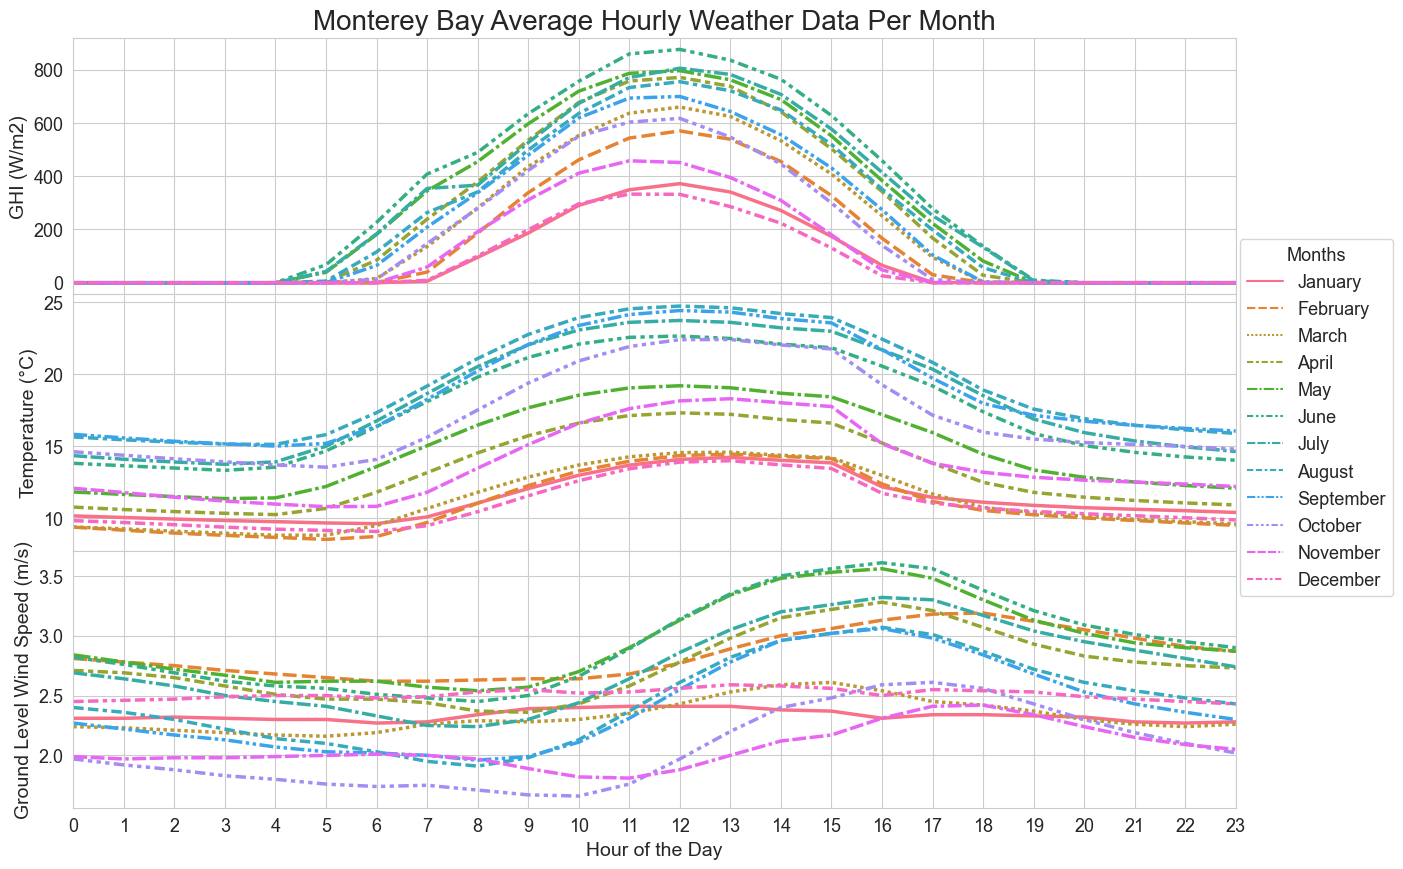

In [6]:
# Monterey Bay Data
#import data
# monterey bay 2018
df_MB18 = pd.read_csv('MB18.csv')
df_MB18.columns = df_MB18.iloc[1]
df_MB18 = df_MB18[2:]

# monterey bay 2019
df_MB19 = pd.read_csv('MB19.csv')
df_MB19.columns = df_MB19.iloc[1]
df_MB19 = df_MB19[2:]

# monterey bay 2020
df_MB20 = pd.read_csv('MB20.csv')
df_MB20.columns = df_MB20.iloc[1]
df_MB20 = df_MB20[2:]

# monterey bay 2021
df_MB21 = pd.read_csv('MB21.csv')
df_MB21.columns = df_MB21.iloc[1]
df_MB21 = df_MB21[2:]

df_MB = pd.DataFrame()
df_MB = pd.concat([df_MB18, df_MB19, df_MB20, df_MB21], ignore_index=True)

# making all values numeric
df_MB['GHI'] = pd.to_numeric(df_MB['GHI'], errors='coerce')
df_MB['Temperature'] = pd.to_numeric(df_MB['Temperature'], errors='coerce')
df_MB['Wind Speed'] = pd.to_numeric(df_MB['Wind Speed'], errors='coerce')

monthlyGHI = []
monthlyTemp = []
monthlyWS = []
MoY = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
# iterate over all months
for month in df_MB['Month'].unique():
    
    idx = df_MB['Month'] == month
    
    # hourly averages for GHI, temp, & wind speed
    hourly_GHI = df_MB[idx].groupby('Hour')['GHI'].mean()
    hourly_Temp = df_MB[idx].groupby('Hour')['Temperature'].mean()
    hourly_WS = df_MB[idx].groupby('Hour')['Wind Speed'].mean()
    
    # sort hour in order from 0 to 23
    hourly_GHI.index = pd.Categorical(hourly_GHI.index.astype(str), categories=[str(i) for i in range(24)], ordered=True)
    hourly_GHI.sort_index(inplace=True)
    
    hourly_Temp.index = pd.Categorical(hourly_Temp.index.astype(str), categories=[str(i) for i in range(24)], ordered=True)
    hourly_Temp.sort_index(inplace=True)
    
    hourly_WS.index = pd.Categorical(hourly_WS.index.astype(str), categories=[str(i) for i in range(24)], ordered=True)
    hourly_WS.sort_index(inplace=True)
    
    # append
    monthlyGHI.append(hourly_GHI)
    monthlyTemp.append(hourly_Temp)
    monthlyWS.append(hourly_WS)
    MoY.append(month)
    
# concatenate
df_MB_GHI = pd.concat(monthlyGHI, axis=1, keys = MoY).round(2)
df_MB_Temp = pd.concat(monthlyTemp, axis=1, keys = MoY).round(2)
df_MB_WS = pd.concat(monthlyWS, axis=1, keys = MoY).round(2)

MB_GHI = np.array(df_MB_GHI)
MB_GHI.resize((288, 1))
MB_Temp = np.array(df_MB_Temp)
MB_Temp.resize((288, 1))
MB_WS = np.array(df_MB_WS)*1.866 # convert to wind speed at hub height
MB_WS.resize((288, 1))


# make plots

# Create subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(15,10))

# Plot GHI data on the first subplot
sns.lineplot(data=df_MB_GHI, linewidth=2.5, ax=ax1)
ax1.set_ylabel('GHI (W/m2)')
ax1.set_title('Monterey Bay Average Hourly Weather Data Per Month', fontsize = 20)
# ax1.set_ylim([0, 900])

# Plot Temperature data on the second subplot
sns.lineplot(data=df_MB_Temp, linewidth=2.5, ax=ax2)
ax2.set_ylabel('Temperature (°C)')
# ax2.set_ylim([10, 23])

# Plot Wind Speed data on the third subplot
sns.lineplot(data=df_MB_WS, linewidth=2.5, ax=ax3)
ax3.set_xlabel('Hour of the Day')
ax3.set_ylabel('Ground Level Wind Speed (m/s)')
ax3.set_xlim([0, 23])
# ax3.set_ylim([1, 4])

# Add legend to the figure
handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, title="Months", title_fontsize=13, loc='center right',bbox_to_anchor=(1.011, 0.5))

# Remove legends from all subplots
ax1.get_legend().remove()
ax2.get_legend().remove()
ax3.get_legend().remove()

# Adjust spacing between the subplots
plt.subplots_adjust(hspace=0)
plt.show()


In [7]:
# calculate solar & wind power gen
pw = np.empty(288)
pv = np.empty(288)
pv_max = np.empty(1)
gen_demand = np.empty(288)
cost_wt = np.empty(288)
cost_pv = np.empty(288)
cost_bb = np.empty(288)


for i in range(288):
    
    # solar power generated
    pv[i] = (prs * (MB_GHI[i]/1000) * (1+ Nt*((MB_Temp[i] + (((Tno - 20)/800) * MB_GHI[i])) - 25)))*30
    
    #wind turbine generated
    if (MB_WS[i] <= WSci):
        pw[i] = 0
    if (MB_WS[i] >= WSco):
        pw[i] = 0
    if (WSr <= MB_WS[i] <= WSco):
        pw[i] = prw*30
    if (WSci <= MB_WS[i] <= WSr):
        pw[i] = (a * MB_WS[i]**3 - b * prw)*30
    
    # power demand at each hour (kW)
    gen_demand[i] = 760000/24 #kW
    
    # cost per hour
    cost_pv[i] = c_pv / 8760
    cost_wt[i] = c_wt / 8760
    cost_bb[i] = c_b / 8760
               
pv_max = np.max(pv)
gen_pv = pv / pv_max

pw_max = np.max(pw)
gen_wt = pw / pw_max

In [8]:
# Optimization of Monterey Bay

# Define optimization variables

#sizes of each system
size_pv = Variable()
size_wt = Variable()
size_bb = Variable()

# battery variables
soc_bb = Variable(289)
Umax = np.ones(288)*Ebmax
Uk = Variable(288)

# optimal power generated for each system
power_pv = Variable(288) 
power_wt = Variable(288)

# power & size constraints
constraints = [power_pv >= 0]
constraints += [power_wt >= 0]
constraints += [size_pv >= 0]
constraints += [size_wt >= 0]
constraints += [size_bb >= 0]

constraints += [soc_bb >= 0]
constraints += [Uk >= 0]
constraints += [Uk <= Umax] 

constraints += [power_pv <= size_pv * gen_pv]
constraints += [power_wt <= size_wt * gen_wt]


# soc
for j in range(288):
    
    # soc constraints
    constraints += [soc_bb[0] ==  0.5*size_bb]
    constraints += [soc_bb[j] <= size_bb]
    constraints += [soc_bb[j] >= 0.2*size_bb]
    constraints += [Uk[j] + power_wt[j] + power_pv[j] >= gen_demand[j]]
    constraints += [soc_bb[j+1] == soc_bb[j]*(1 - sigma) + (Uk[j])]
    constraints += [power_pv[j] - power_pv[j-1] <= 0.3*size_pv]
    constraints += [power_wt[j] - power_wt[j-1] <= 0.3*size_wt]


# # sum hourly costs for pv and wt
Cost_pv = sum(size_pv * cost_pv)
Cost_wt = sum(size_wt * cost_wt) 
Cost_bb = sum(size_bb * cost_bb)

objective = Minimize(Cost_pv + Cost_wt + Cost_bb) 

# Define problem and solve
prob2 = Problem(objective, constraints)
prob2.solve(solver = ECOS_BB)
print("Minimum Desal Plant Operating Cost at Monterey Bay: %4.2f"%(prob2.value),"USD/yr")
print("PV Size:", size_pv.value, "kW")
print("WT Size:", size_wt.value, "kW")
print("Battery Size:", size_bb.value, "kW")
print("PV Cost:", Cost_pv.value, "USD")
print("WT Cost:", Cost_wt.value, "USD")
print("Battery Cost:", Cost_bb.value, "USD")

Minimum Desal Plant Operating Cost at Monterey Bay: 6327187759.07 USD/yr
PV Size: 798991.618787298 kW
WT Size: 810162.1281055082 kW
Battery Size: 13766.178595895088 kW
PV Cost: 404530.5511010757 USD
WT Cost: 5180598375.3376875 USD
Battery Cost: 1146184853.183876 USD


# Santa Barbara Analysis

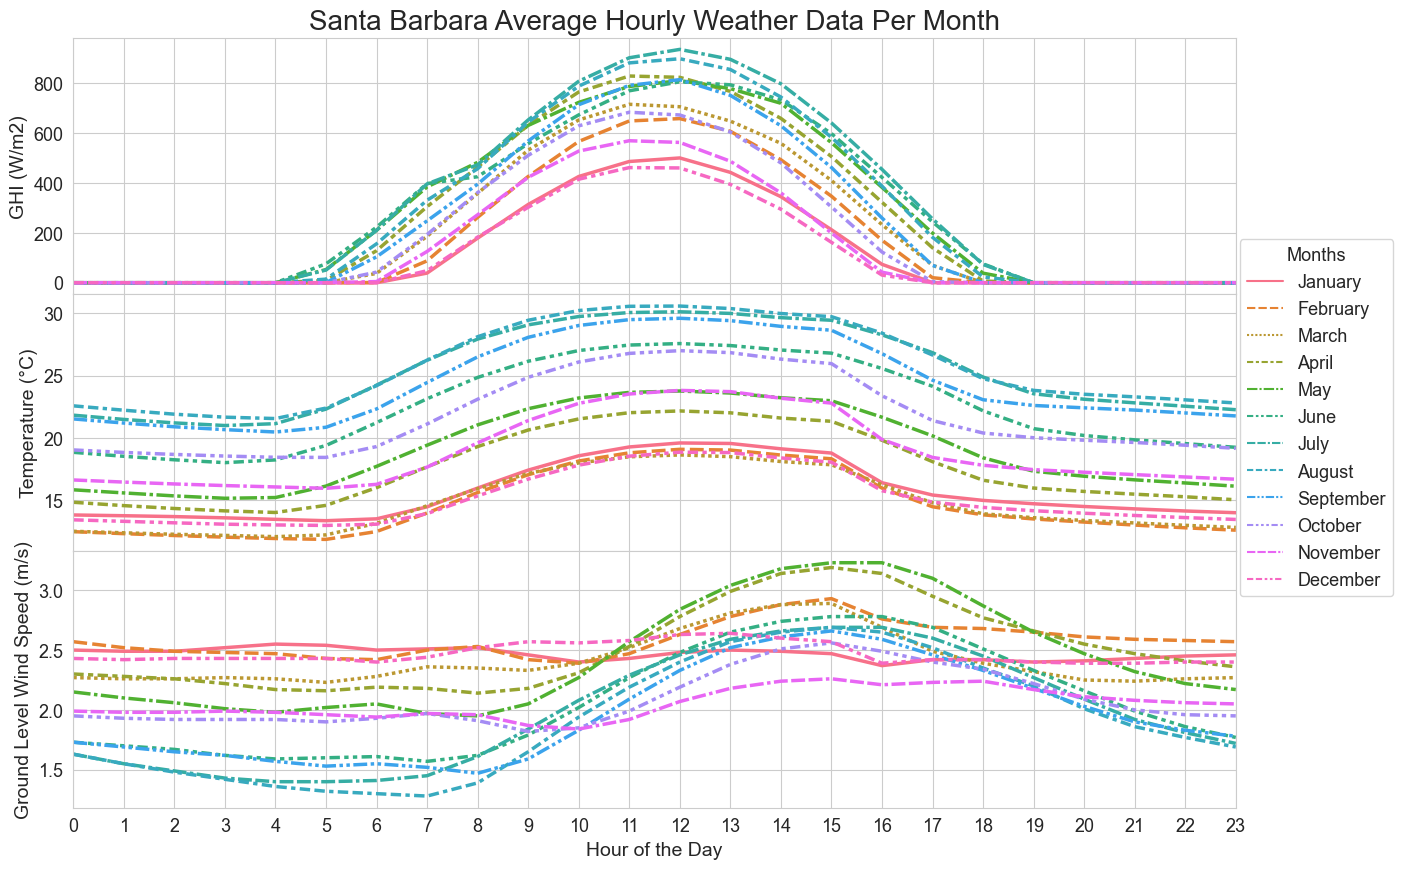

In [9]:
# Santa Barbara Data
# import data
# santa barbara 2018
df_SB18 = pd.read_csv('SB18.csv')
df_SB18.columns = df_SB18.iloc[1]
df_SB18 = df_SB18[2:]

# santa barbara 2019
df_SB19 = pd.read_csv('SB19.csv')
df_SB19.columns = df_SB19.iloc[1]
df_SB19 = df_SB19[2:]

# santa barbara 2020
df_SB20 = pd.read_csv('SB20.csv')
df_SB20.columns = df_SB20.iloc[1]
df_SB20 = df_SB20[2:]

# santa barbara 2021
df_SB21 = pd.read_csv('SB21.csv')
df_SB21.columns = df_SB21.iloc[1]
df_SB21 = df_SB21[2:]

df_SB = pd.DataFrame()
df_SB = pd.concat([df_SB18, df_SB19, df_SB20, df_SB21], ignore_index=True)

# making all values numeric
df_SB['GHI'] = pd.to_numeric(df_SB['GHI'], errors='coerce')
df_SB['Temperature'] = pd.to_numeric(df_SB['Temperature'], errors='coerce')
df_SB['Wind Speed'] = pd.to_numeric(df_SB['Wind Speed'], errors='coerce')


monthlyGHI = []
monthlyTemp = []
monthlyWS = []
MoY = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

# iterate over all months
for month in df_SB['Month'].unique():

    idx = df_SB['Month'] == month
    
    # hourly averages for GHI, temp, & wind speed
    hourly_GHI = df_SB[idx].groupby('Hour')['GHI'].mean()
    hourly_Temp = df_SB[idx].groupby('Hour')['Temperature'].mean()
    hourly_WS = df_SB[idx].groupby('Hour')['Wind Speed'].mean()
    
   # sort hour in order from 0 to 23
    hourly_GHI.index = pd.Categorical(hourly_GHI.index.astype(str), categories=[str(i) for i in range(24)], ordered=True)
    hourly_GHI.sort_index(inplace=True)
    
    hourly_Temp.index = pd.Categorical(hourly_Temp.index.astype(str), categories=[str(i) for i in range(24)], ordered=True)
    hourly_Temp.sort_index(inplace=True)
    
    hourly_WS.index = pd.Categorical(hourly_WS.index.astype(str), categories=[str(i) for i in range(24)], ordered=True)
    hourly_WS.sort_index(inplace=True)
    
    # append
    monthlyGHI.append(hourly_GHI)
    monthlyTemp.append(hourly_Temp)
    monthlyWS.append(hourly_WS)
    MoY.append(month)
    
# concatenate
df_SB_GHI = pd.concat(monthlyGHI, axis=1, keys = MoY).round(2)
df_SB_Temp = pd.concat(monthlyTemp, axis=1, keys = MoY).round(2)
df_SB_WS = pd.concat(monthlyWS, axis=1, keys = MoY).round(2)

SB_GHI = np.array(df_SB_GHI)
SB_GHI.resize((288, 1))
SB_Temp = np.array(df_SB_Temp)
SB_Temp.resize((288, 1))
SB_WS = np.array(df_SB_WS)*1.866 # convert to wind speed at hub height
SB_WS.resize((288, 1))

# make plots

# Create subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(15,10))

# Plot GHI data on the first subplot
sns.lineplot(data=df_SB_GHI, linewidth=2.5, ax=ax1)
ax1.set_ylabel('GHI (W/m2)')
ax1.set_title('Santa Barbara Average Hourly Weather Data Per Month', fontsize = 20)

# Plot Temperature data on the second subplot
sns.lineplot(data=df_SB_Temp, linewidth=2.5, ax=ax2)
ax2.set_ylabel('Temperature (°C)')

# Plot Wind Speed data on the third subplot
sns.lineplot(data=df_SB_WS, linewidth=2.5, ax=ax3)
ax3.set_xlabel('Hour of the Day')
ax3.set_ylabel('Ground Level Wind Speed (m/s)')
ax3.set_xlim([0, 23])

# Add legend to the figure
handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, title="Months", title_fontsize=13, loc='center right',bbox_to_anchor=(1.011, 0.5))

# Remove legends from all subplots
ax1.get_legend().remove()
ax2.get_legend().remove()
ax3.get_legend().remove()

# Adjust spacing between the subplots
plt.subplots_adjust(hspace=0)
plt.show()                             

In [10]:
# calculate solar & wind power gen
pw = np.empty(288)
pv = np.empty(288)
pv_max = np.empty(1)
gen_demand = np.empty(288)
cost_wt = np.empty(288)
cost_pv = np.empty(288)
cost_bb = np.empty(288)


for i in range(288):
    
    # solar power generated
    pv[i] = (prs * (SB_GHI[i]/1000) * (1+ Nt*((SB_Temp[i] + (((Tno - 20)/800) * SB_GHI[i])) - 25)))*30
    
    #wind turbine generated
    if (SB_WS[i] <= WSci):
        pw[i] = 0
    if (SB_WS[i] >= WSco):
        pw[i] = 0
    if (WSr <= SB_WS[i] <= WSco):
        pw[i] = prw*30
    if (WSci <= SB_WS[i] <= WSr):
        pw[i] = (a * SB_WS[i]**3 - b * prw)*30
    
    # power demand at each hour (kW)
    gen_demand[i] = 760000 / 24 #kWh
    
    # cost per hour
    cost_pv[i] = c_pv / 8760
    cost_wt[i] = c_wt / 8760
    cost_bb[i] = c_b / 8760
               
pv_max = np.max(pv)
gen_pv = pv / pv_max

pw_max = np.max(pw)
gen_wt = pw / pw_max

In [11]:
# Optimization of Santa Barbara

# Define optimization variables

#sizes of each system
size_pv = Variable()
size_wt = Variable()
size_bb = Variable()

# battery variables
soc_bb = Variable(289)
Umax = np.ones(288)*Ebmax
Uk = Variable(288)

# optimal power generated for each system
power_pv = Variable(288) 
power_wt = Variable(288)

# power & size constraints
constraints = [power_pv >= 0]
constraints += [power_wt >= 0]
constraints += [size_pv >= 0]
constraints += [size_wt >= 0]
constraints += [size_bb >= 0]

constraints += [soc_bb >= 0]
constraints += [Uk >= 0]
constraints += [Uk <= Umax] 

constraints += [power_pv <= size_pv * gen_pv]
constraints += [power_wt <= size_wt * gen_wt]


# soc
for j in range(288):
    
    # soc constraints
    constraints += [soc_bb[0] ==  0.5*size_bb]
    constraints += [soc_bb[j] <= size_bb]
    constraints += [soc_bb[j] >= 0.2*size_bb]
    constraints += [Uk[j] + power_wt[j] + power_pv[j] >= gen_demand[j]]
    constraints += [soc_bb[j+1] == soc_bb[j]*(1 - sigma) + (Uk[j])]
    constraints += [power_pv[j] - power_pv[j-1] <= 0.3*size_pv]
    constraints += [power_wt[j] - power_wt[j-1] <= 0.3*size_wt]


# # sum hourly costs for pv and wt
Cost_pv = sum(size_pv * cost_pv)
Cost_wt = sum(size_wt * cost_wt) 
Cost_bb = sum(size_bb * cost_bb)

objective = Minimize(Cost_pv + Cost_wt + Cost_bb) 

# Define problem and solve
prob3 = Problem(objective, constraints)
prob3.solve(solver = ECOS_BB)
print("Minimum Desal Plant Operating Cost at Santa Barbara: %4.2f"%(prob3.value),"USD/yr")
print("PV Size:", size_pv.value, "kW")
print("WT Size:", size_wt.value, "kW")
print("Battery Size:", size_bb.value, "kW")
print("PV Cost:", Cost_pv.value, "USD")
print("WT Cost:", Cost_wt.value, "USD")
print("Battery Cost:", Cost_bb.value, "USD")

Minimum Desal Plant Operating Cost at Santa Barbara: 78722893354.18 USD/yr
PV Size: 56878259.73505856 kW
WT Size: 1863919.1621210957 kW
Battery Size: 801999.5119316323 kW
PV Cost: 28797540.819284447 USD
WT Cost: 11918869381.892157 USD
Battery Cost: 66775226431.46622 USD


# Data Analysis

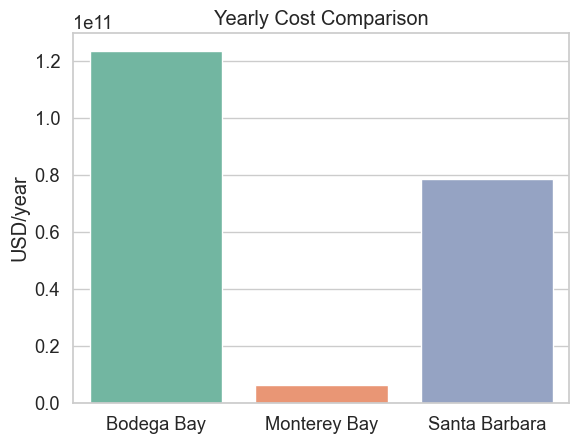

In [12]:
# compare costs
solutions = [prob1.value, prob2.value, prob3.value]
names = ['Bodega Bay', 'Monterey Bay', 'Santa Barbara']
sns.set(style="whitegrid", font_scale=1.2)
sns.color_palette("pastel")
sns.barplot(x=names, y=solutions, palette="Set2")
plt.title('Yearly Cost Comparison')
plt.xlabel('')
plt.ylabel('USD/year')
plt.show()